# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)


Found mnist Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

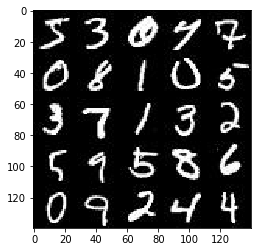

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/venkata/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, (None, image_height,image_width,image_channels), name='input_images')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_images, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [18]:
def discriminator(images, reuse=False , alpha =0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x_
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # Each stride 2 with padding = same doubles the dimension, and you 
    # want to end up with 28, so you have to pick a factor of 28 divisible by 2.
    # i.e. you can pick 28, 14, or 7. (7, 7, 256)
    # I started with 7, and then I doubled it twice.

    tf.Print(out_channel_dim, [out_channel_dim] , " Test: ")
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        # TODO do we need batch normalization at first layer
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [28]:
def model_loss(input_real, input_z, out_channel_dim , alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True , alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real,reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [29]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [32]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [45]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
    input_real, input_z, lr =  model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z , lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images , lr:learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    
        saver.save(sess, './checkpoints/generator.ckpt')
                    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/100... Discriminator Loss: 2.1327... Generator Loss: 0.2097
Epoch 1/100... Discriminator Loss: 1.7582... Generator Loss: 0.4142
Epoch 1/100... Discriminator Loss: 1.7271... Generator Loss: 0.5267
Epoch 1/100... Discriminator Loss: 1.4066... Generator Loss: 0.7671
Epoch 1/100... Discriminator Loss: 1.2597... Generator Loss: 0.8561
Epoch 1/100... Discriminator Loss: 1.3080... Generator Loss: 0.7171
Epoch 1/100... Discriminator Loss: 1.2853... Generator Loss: 0.7493
Epoch 1/100... Discriminator Loss: 1.2443... Generator Loss: 1.0901
Epoch 1/100... Discriminator Loss: 1.2109... Generator Loss: 1.2073
Epoch 1/100... Discriminator Loss: 0.9786... Generator Loss: 1.3840


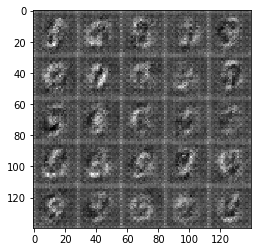

Epoch 1/100... Discriminator Loss: 0.9368... Generator Loss: 1.2734
Epoch 1/100... Discriminator Loss: 0.8979... Generator Loss: 0.9978
Epoch 1/100... Discriminator Loss: 0.8173... Generator Loss: 1.2464
Epoch 1/100... Discriminator Loss: 0.7406... Generator Loss: 1.1535
Epoch 1/100... Discriminator Loss: 1.0949... Generator Loss: 0.6474
Epoch 1/100... Discriminator Loss: 0.9377... Generator Loss: 1.4437
Epoch 1/100... Discriminator Loss: 1.0744... Generator Loss: 0.5714
Epoch 1/100... Discriminator Loss: 0.9887... Generator Loss: 1.0711
Epoch 1/100... Discriminator Loss: 0.7772... Generator Loss: 1.2591
Epoch 1/100... Discriminator Loss: 0.9220... Generator Loss: 1.0667


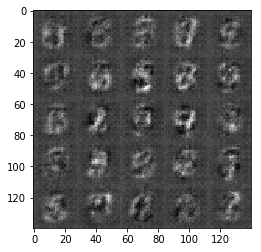

Epoch 1/100... Discriminator Loss: 0.9662... Generator Loss: 1.3169
Epoch 1/100... Discriminator Loss: 0.8102... Generator Loss: 1.3103
Epoch 1/100... Discriminator Loss: 0.7402... Generator Loss: 1.3057
Epoch 1/100... Discriminator Loss: 0.7800... Generator Loss: 1.3931
Epoch 1/100... Discriminator Loss: 0.7743... Generator Loss: 1.0703
Epoch 1/100... Discriminator Loss: 0.7730... Generator Loss: 1.2979
Epoch 1/100... Discriminator Loss: 0.7809... Generator Loss: 1.7072
Epoch 1/100... Discriminator Loss: 0.9224... Generator Loss: 2.0054
Epoch 1/100... Discriminator Loss: 0.6698... Generator Loss: 1.1596
Epoch 1/100... Discriminator Loss: 0.7790... Generator Loss: 1.8190


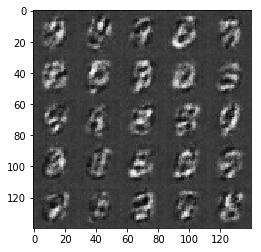

Epoch 1/100... Discriminator Loss: 0.6705... Generator Loss: 1.0399
Epoch 1/100... Discriminator Loss: 0.7028... Generator Loss: 0.8919
Epoch 1/100... Discriminator Loss: 0.7553... Generator Loss: 1.9342
Epoch 1/100... Discriminator Loss: 0.6148... Generator Loss: 1.2989
Epoch 1/100... Discriminator Loss: 0.6006... Generator Loss: 2.0836
Epoch 1/100... Discriminator Loss: 0.6834... Generator Loss: 0.9881
Epoch 1/100... Discriminator Loss: 0.6503... Generator Loss: 2.2978
Epoch 1/100... Discriminator Loss: 0.6089... Generator Loss: 1.5562
Epoch 1/100... Discriminator Loss: 0.7424... Generator Loss: 2.2626
Epoch 1/100... Discriminator Loss: 0.6428... Generator Loss: 0.9848


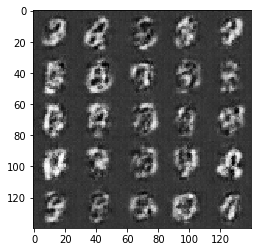

Epoch 1/100... Discriminator Loss: 0.5204... Generator Loss: 1.8618
Epoch 1/100... Discriminator Loss: 0.5132... Generator Loss: 1.1982
Epoch 1/100... Discriminator Loss: 0.8720... Generator Loss: 2.8976
Epoch 1/100... Discriminator Loss: 0.5516... Generator Loss: 1.1788
Epoch 1/100... Discriminator Loss: 0.5930... Generator Loss: 1.0410
Epoch 1/100... Discriminator Loss: 0.5797... Generator Loss: 1.0624
Epoch 2/100... Discriminator Loss: 0.5465... Generator Loss: 1.5953
Epoch 2/100... Discriminator Loss: 0.4120... Generator Loss: 1.9073
Epoch 2/100... Discriminator Loss: 0.5552... Generator Loss: 1.1480
Epoch 2/100... Discriminator Loss: 0.4377... Generator Loss: 1.8066


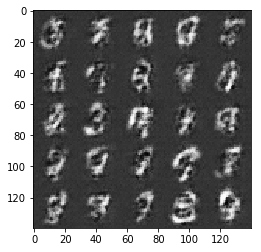

Epoch 2/100... Discriminator Loss: 0.3804... Generator Loss: 1.6019
Epoch 2/100... Discriminator Loss: 0.4814... Generator Loss: 1.2660
Epoch 2/100... Discriminator Loss: 0.4080... Generator Loss: 1.8812
Epoch 2/100... Discriminator Loss: 0.5425... Generator Loss: 1.1033
Epoch 2/100... Discriminator Loss: 0.4802... Generator Loss: 2.4213
Epoch 2/100... Discriminator Loss: 0.3918... Generator Loss: 2.2075
Epoch 2/100... Discriminator Loss: 0.3389... Generator Loss: 1.8696
Epoch 2/100... Discriminator Loss: 0.5938... Generator Loss: 2.9091
Epoch 2/100... Discriminator Loss: 0.4133... Generator Loss: 1.8751
Epoch 2/100... Discriminator Loss: 0.3388... Generator Loss: 1.9003


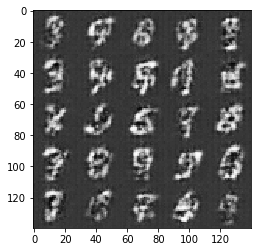

Epoch 2/100... Discriminator Loss: 0.3565... Generator Loss: 2.4328
Epoch 2/100... Discriminator Loss: 0.2436... Generator Loss: 2.2167
Epoch 2/100... Discriminator Loss: 0.3446... Generator Loss: 2.0049
Epoch 2/100... Discriminator Loss: 0.6145... Generator Loss: 0.9348
Epoch 2/100... Discriminator Loss: 0.3413... Generator Loss: 1.7904
Epoch 2/100... Discriminator Loss: 0.3469... Generator Loss: 1.7798
Epoch 2/100... Discriminator Loss: 0.3475... Generator Loss: 1.6980
Epoch 2/100... Discriminator Loss: 0.5223... Generator Loss: 1.1551
Epoch 2/100... Discriminator Loss: 0.2768... Generator Loss: 2.0170
Epoch 2/100... Discriminator Loss: 0.3661... Generator Loss: 2.0610


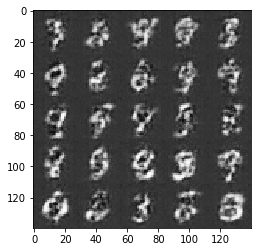

Epoch 2/100... Discriminator Loss: 0.2806... Generator Loss: 2.0621
Epoch 2/100... Discriminator Loss: 0.2547... Generator Loss: 2.5696
Epoch 2/100... Discriminator Loss: 0.3111... Generator Loss: 2.1916
Epoch 2/100... Discriminator Loss: 0.2539... Generator Loss: 2.1620
Epoch 2/100... Discriminator Loss: 0.3502... Generator Loss: 2.5846
Epoch 2/100... Discriminator Loss: 0.2489... Generator Loss: 2.1830
Epoch 2/100... Discriminator Loss: 0.2411... Generator Loss: 2.1847
Epoch 2/100... Discriminator Loss: 0.2796... Generator Loss: 2.0304
Epoch 2/100... Discriminator Loss: 0.2716... Generator Loss: 2.1618
Epoch 2/100... Discriminator Loss: 0.3492... Generator Loss: 3.1171


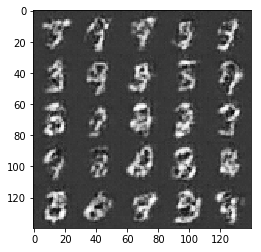

Epoch 2/100... Discriminator Loss: 0.3086... Generator Loss: 1.7265
Epoch 2/100... Discriminator Loss: 0.2390... Generator Loss: 2.4394
Epoch 2/100... Discriminator Loss: 0.2494... Generator Loss: 2.0464
Epoch 2/100... Discriminator Loss: 0.3006... Generator Loss: 1.7559
Epoch 2/100... Discriminator Loss: 0.2248... Generator Loss: 2.1894
Epoch 2/100... Discriminator Loss: 0.2980... Generator Loss: 1.7684
Epoch 2/100... Discriminator Loss: 0.2892... Generator Loss: 1.8629
Epoch 2/100... Discriminator Loss: 0.9385... Generator Loss: 4.7966
Epoch 2/100... Discriminator Loss: 0.3462... Generator Loss: 1.9577
Epoch 2/100... Discriminator Loss: 0.2597... Generator Loss: 2.2830


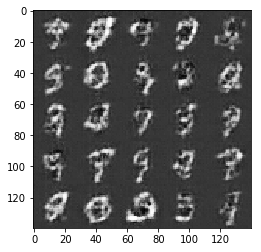

Epoch 2/100... Discriminator Loss: 0.3996... Generator Loss: 1.8302
Epoch 2/100... Discriminator Loss: 0.2893... Generator Loss: 1.8607
Epoch 2/100... Discriminator Loss: 0.3055... Generator Loss: 1.9001
Epoch 3/100... Discriminator Loss: 0.2528... Generator Loss: 2.1897
Epoch 3/100... Discriminator Loss: 0.4066... Generator Loss: 3.5408
Epoch 3/100... Discriminator Loss: 0.2384... Generator Loss: 2.2704
Epoch 3/100... Discriminator Loss: 0.2638... Generator Loss: 2.2061
Epoch 3/100... Discriminator Loss: 0.2695... Generator Loss: 1.9694
Epoch 3/100... Discriminator Loss: 0.4004... Generator Loss: 1.5404
Epoch 3/100... Discriminator Loss: 0.2163... Generator Loss: 2.6124


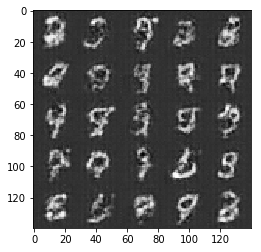

Epoch 3/100... Discriminator Loss: 0.2903... Generator Loss: 2.2794
Epoch 3/100... Discriminator Loss: 0.2616... Generator Loss: 2.2280
Epoch 3/100... Discriminator Loss: 0.2849... Generator Loss: 2.4717
Epoch 3/100... Discriminator Loss: 0.3556... Generator Loss: 3.1214
Epoch 3/100... Discriminator Loss: 0.3125... Generator Loss: 1.7930
Epoch 3/100... Discriminator Loss: 0.5148... Generator Loss: 1.0959
Epoch 3/100... Discriminator Loss: 0.2891... Generator Loss: 2.1430
Epoch 3/100... Discriminator Loss: 0.2898... Generator Loss: 2.1025
Epoch 3/100... Discriminator Loss: 0.2274... Generator Loss: 2.3309
Epoch 3/100... Discriminator Loss: 0.2416... Generator Loss: 3.1805


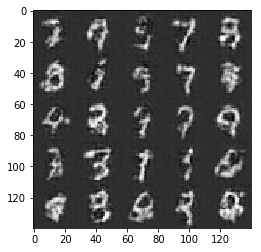

Epoch 3/100... Discriminator Loss: 0.3520... Generator Loss: 2.4530
Epoch 3/100... Discriminator Loss: 0.2147... Generator Loss: 2.5199
Epoch 3/100... Discriminator Loss: 0.3653... Generator Loss: 1.5717
Epoch 3/100... Discriminator Loss: 0.1992... Generator Loss: 2.4768
Epoch 3/100... Discriminator Loss: 0.6614... Generator Loss: 1.0840
Epoch 3/100... Discriminator Loss: 0.3370... Generator Loss: 1.7871
Epoch 3/100... Discriminator Loss: 0.3601... Generator Loss: 1.8677
Epoch 3/100... Discriminator Loss: 0.2992... Generator Loss: 2.1068
Epoch 3/100... Discriminator Loss: 0.3487... Generator Loss: 1.7707
Epoch 3/100... Discriminator Loss: 0.2805... Generator Loss: 2.0590


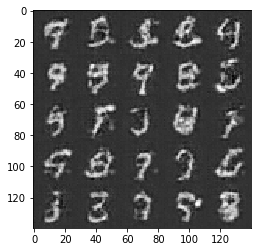

Epoch 3/100... Discriminator Loss: 0.2783... Generator Loss: 1.8814
Epoch 3/100... Discriminator Loss: 0.3011... Generator Loss: 1.8826
Epoch 3/100... Discriminator Loss: 0.3068... Generator Loss: 1.8529
Epoch 3/100... Discriminator Loss: 0.3125... Generator Loss: 2.1186
Epoch 3/100... Discriminator Loss: 0.7528... Generator Loss: 4.1133
Epoch 3/100... Discriminator Loss: 0.3691... Generator Loss: 1.7999
Epoch 3/100... Discriminator Loss: 0.3152... Generator Loss: 1.7366
Epoch 3/100... Discriminator Loss: 0.2652... Generator Loss: 2.3855
Epoch 3/100... Discriminator Loss: 0.3663... Generator Loss: 1.5332
Epoch 3/100... Discriminator Loss: 0.2715... Generator Loss: 1.9573


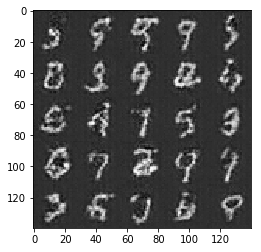

Epoch 3/100... Discriminator Loss: 0.2901... Generator Loss: 2.6364
Epoch 3/100... Discriminator Loss: 0.2736... Generator Loss: 1.9316
Epoch 3/100... Discriminator Loss: 0.5922... Generator Loss: 1.0337
Epoch 3/100... Discriminator Loss: 0.2904... Generator Loss: 2.8630
Epoch 3/100... Discriminator Loss: 0.4084... Generator Loss: 1.7522
Epoch 3/100... Discriminator Loss: 0.3247... Generator Loss: 2.2433
Epoch 3/100... Discriminator Loss: 0.3219... Generator Loss: 2.0530
Epoch 3/100... Discriminator Loss: 0.2870... Generator Loss: 2.0275
Epoch 3/100... Discriminator Loss: 0.2900... Generator Loss: 1.9895
Epoch 3/100... Discriminator Loss: 0.2516... Generator Loss: 2.5004


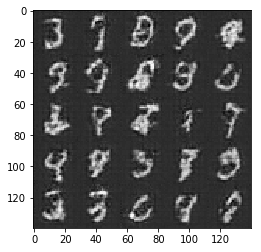

Epoch 4/100... Discriminator Loss: 0.2716... Generator Loss: 2.1064
Epoch 4/100... Discriminator Loss: 0.4239... Generator Loss: 2.7450
Epoch 4/100... Discriminator Loss: 0.3033... Generator Loss: 2.2488
Epoch 4/100... Discriminator Loss: 0.2571... Generator Loss: 2.0058
Epoch 4/100... Discriminator Loss: 0.2128... Generator Loss: 2.3718
Epoch 4/100... Discriminator Loss: 0.3762... Generator Loss: 1.5633
Epoch 4/100... Discriminator Loss: 0.3267... Generator Loss: 1.7914
Epoch 4/100... Discriminator Loss: 0.2752... Generator Loss: 2.2107
Epoch 4/100... Discriminator Loss: 0.2882... Generator Loss: 1.8377
Epoch 4/100... Discriminator Loss: 0.2421... Generator Loss: 2.2500


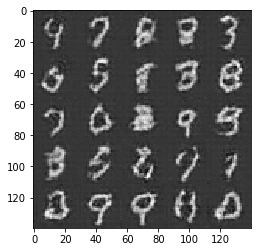

Epoch 4/100... Discriminator Loss: 0.4104... Generator Loss: 4.1183
Epoch 4/100... Discriminator Loss: 0.2825... Generator Loss: 2.1691
Epoch 4/100... Discriminator Loss: 0.2576... Generator Loss: 2.1427
Epoch 4/100... Discriminator Loss: 0.4555... Generator Loss: 1.2844
Epoch 4/100... Discriminator Loss: 0.4316... Generator Loss: 1.4189
Epoch 4/100... Discriminator Loss: 0.3948... Generator Loss: 1.4570
Epoch 4/100... Discriminator Loss: 0.4052... Generator Loss: 1.4293
Epoch 4/100... Discriminator Loss: 0.2372... Generator Loss: 2.7114
Epoch 4/100... Discriminator Loss: 0.1932... Generator Loss: 2.8715
Epoch 4/100... Discriminator Loss: 0.4719... Generator Loss: 1.2698


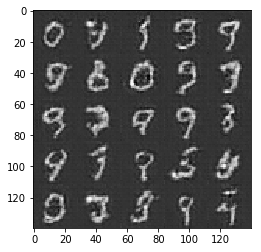

Epoch 4/100... Discriminator Loss: 0.3405... Generator Loss: 2.8587
Epoch 4/100... Discriminator Loss: 0.3400... Generator Loss: 2.0580
Epoch 4/100... Discriminator Loss: 0.2669... Generator Loss: 2.0476
Epoch 4/100... Discriminator Loss: 0.3112... Generator Loss: 1.7841
Epoch 4/100... Discriminator Loss: 0.2783... Generator Loss: 2.2018
Epoch 4/100... Discriminator Loss: 0.2675... Generator Loss: 2.2171
Epoch 4/100... Discriminator Loss: 0.1881... Generator Loss: 2.6889
Epoch 4/100... Discriminator Loss: 0.3028... Generator Loss: 1.9375
Epoch 4/100... Discriminator Loss: 0.4345... Generator Loss: 4.4357
Epoch 4/100... Discriminator Loss: 0.3219... Generator Loss: 2.0345


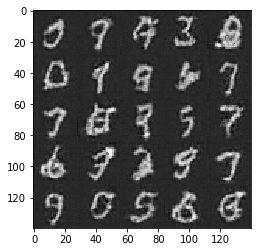

Epoch 4/100... Discriminator Loss: 0.2382... Generator Loss: 2.2611
Epoch 4/100... Discriminator Loss: 0.2719... Generator Loss: 2.0492
Epoch 4/100... Discriminator Loss: 0.4231... Generator Loss: 1.4001
Epoch 4/100... Discriminator Loss: 0.2817... Generator Loss: 1.8143
Epoch 4/100... Discriminator Loss: 0.1875... Generator Loss: 2.8765
Epoch 4/100... Discriminator Loss: 0.1737... Generator Loss: 2.6351
Epoch 4/100... Discriminator Loss: 0.2001... Generator Loss: 2.8782
Epoch 4/100... Discriminator Loss: 0.3160... Generator Loss: 3.2614
Epoch 4/100... Discriminator Loss: 0.3012... Generator Loss: 2.3822
Epoch 4/100... Discriminator Loss: 0.9440... Generator Loss: 0.6638


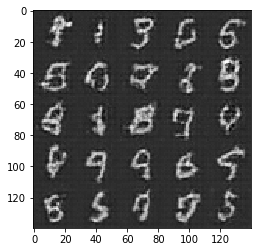

Epoch 4/100... Discriminator Loss: 0.3026... Generator Loss: 1.8560
Epoch 4/100... Discriminator Loss: 0.3009... Generator Loss: 2.4088
Epoch 4/100... Discriminator Loss: 0.5236... Generator Loss: 1.1520
Epoch 4/100... Discriminator Loss: 0.3085... Generator Loss: 1.8558
Epoch 4/100... Discriminator Loss: 0.3404... Generator Loss: 2.4396
Epoch 4/100... Discriminator Loss: 0.2756... Generator Loss: 1.9953
Epoch 4/100... Discriminator Loss: 0.2493... Generator Loss: 2.4491
Epoch 5/100... Discriminator Loss: 0.2640... Generator Loss: 2.1256
Epoch 5/100... Discriminator Loss: 2.2909... Generator Loss: 5.3561
Epoch 5/100... Discriminator Loss: 0.9171... Generator Loss: 0.9843


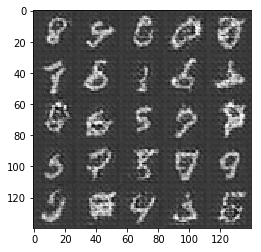

Epoch 5/100... Discriminator Loss: 0.3261... Generator Loss: 1.9722
Epoch 5/100... Discriminator Loss: 0.2914... Generator Loss: 2.2959
Epoch 5/100... Discriminator Loss: 0.3124... Generator Loss: 1.9193
Epoch 5/100... Discriminator Loss: 0.4244... Generator Loss: 1.3889
Epoch 5/100... Discriminator Loss: 0.2689... Generator Loss: 2.1917
Epoch 5/100... Discriminator Loss: 0.1623... Generator Loss: 2.5682
Epoch 5/100... Discriminator Loss: 0.1908... Generator Loss: 2.6176
Epoch 5/100... Discriminator Loss: 0.2385... Generator Loss: 2.4578
Epoch 5/100... Discriminator Loss: 0.2481... Generator Loss: 2.1168
Epoch 5/100... Discriminator Loss: 0.4089... Generator Loss: 1.4464


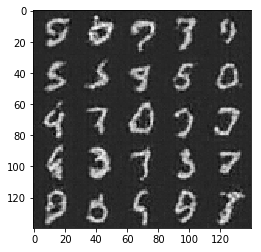

Epoch 5/100... Discriminator Loss: 0.4162... Generator Loss: 1.3843
Epoch 5/100... Discriminator Loss: 0.3384... Generator Loss: 1.7153
Epoch 5/100... Discriminator Loss: 0.2774... Generator Loss: 2.3476
Epoch 5/100... Discriminator Loss: 0.3485... Generator Loss: 1.6192
Epoch 5/100... Discriminator Loss: 0.2654... Generator Loss: 2.1717
Epoch 5/100... Discriminator Loss: 0.2427... Generator Loss: 2.2915
Epoch 5/100... Discriminator Loss: 0.2340... Generator Loss: 2.3772
Epoch 5/100... Discriminator Loss: 0.3577... Generator Loss: 3.1826
Epoch 5/100... Discriminator Loss: 0.9473... Generator Loss: 0.7205
Epoch 5/100... Discriminator Loss: 0.3851... Generator Loss: 1.7214


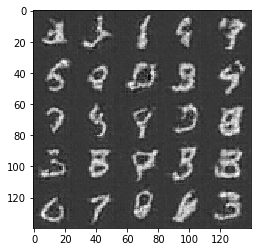

Epoch 5/100... Discriminator Loss: 0.2966... Generator Loss: 2.0635
Epoch 5/100... Discriminator Loss: 0.2502... Generator Loss: 2.5245
Epoch 5/100... Discriminator Loss: 0.2796... Generator Loss: 2.3054
Epoch 5/100... Discriminator Loss: 0.2275... Generator Loss: 2.1944
Epoch 5/100... Discriminator Loss: 0.3652... Generator Loss: 1.5997
Epoch 5/100... Discriminator Loss: 0.3808... Generator Loss: 3.0624
Epoch 5/100... Discriminator Loss: 0.2311... Generator Loss: 2.0219
Epoch 5/100... Discriminator Loss: 0.2220... Generator Loss: 2.2382
Epoch 5/100... Discriminator Loss: 0.3760... Generator Loss: 2.3714
Epoch 5/100... Discriminator Loss: 0.2066... Generator Loss: 2.5873


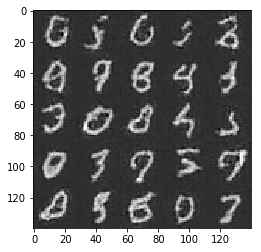

Epoch 5/100... Discriminator Loss: 0.2696... Generator Loss: 2.6730
Epoch 5/100... Discriminator Loss: 0.3854... Generator Loss: 1.5142
Epoch 5/100... Discriminator Loss: 0.2669... Generator Loss: 2.7057
Epoch 5/100... Discriminator Loss: 0.2464... Generator Loss: 2.1810
Epoch 5/100... Discriminator Loss: 0.4229... Generator Loss: 1.3303
Epoch 5/100... Discriminator Loss: 0.2135... Generator Loss: 2.5573
Epoch 5/100... Discriminator Loss: 0.2344... Generator Loss: 2.9257
Epoch 5/100... Discriminator Loss: 0.2112... Generator Loss: 2.4208
Epoch 5/100... Discriminator Loss: 0.2592... Generator Loss: 1.9195
Epoch 5/100... Discriminator Loss: 0.2889... Generator Loss: 2.1860


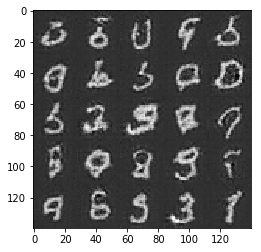

Epoch 5/100... Discriminator Loss: 0.1988... Generator Loss: 2.4651
Epoch 5/100... Discriminator Loss: 0.2887... Generator Loss: 1.9574
Epoch 5/100... Discriminator Loss: 0.2882... Generator Loss: 1.9996
Epoch 5/100... Discriminator Loss: 0.1732... Generator Loss: 2.8309
Epoch 6/100... Discriminator Loss: 0.2605... Generator Loss: 2.1519
Epoch 6/100... Discriminator Loss: 0.8852... Generator Loss: 1.5147
Epoch 6/100... Discriminator Loss: 0.5482... Generator Loss: 1.4043
Epoch 6/100... Discriminator Loss: 0.4132... Generator Loss: 1.6479
Epoch 6/100... Discriminator Loss: 0.5062... Generator Loss: 1.2863
Epoch 6/100... Discriminator Loss: 0.2741... Generator Loss: 2.0485


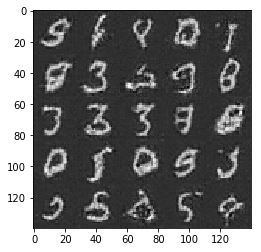

Epoch 6/100... Discriminator Loss: 0.3901... Generator Loss: 1.6356
Epoch 6/100... Discriminator Loss: 0.2376... Generator Loss: 2.2052
Epoch 6/100... Discriminator Loss: 0.2649... Generator Loss: 2.1751
Epoch 6/100... Discriminator Loss: 0.2050... Generator Loss: 2.7122
Epoch 6/100... Discriminator Loss: 0.2619... Generator Loss: 2.8147
Epoch 6/100... Discriminator Loss: 0.2282... Generator Loss: 2.6330
Epoch 6/100... Discriminator Loss: 0.3923... Generator Loss: 1.4810
Epoch 6/100... Discriminator Loss: 0.2566... Generator Loss: 2.0545
Epoch 6/100... Discriminator Loss: 0.2863... Generator Loss: 2.4978
Epoch 6/100... Discriminator Loss: 0.3092... Generator Loss: 2.5720


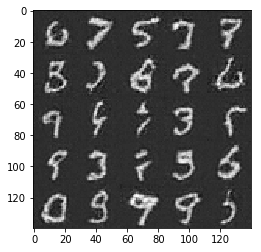

Epoch 6/100... Discriminator Loss: 0.2346... Generator Loss: 2.2598
Epoch 6/100... Discriminator Loss: 0.2213... Generator Loss: 2.4813
Epoch 6/100... Discriminator Loss: 0.1318... Generator Loss: 2.9577
Epoch 6/100... Discriminator Loss: 0.6471... Generator Loss: 2.2324
Epoch 6/100... Discriminator Loss: 0.6350... Generator Loss: 1.1209
Epoch 6/100... Discriminator Loss: 0.2956... Generator Loss: 2.0542
Epoch 6/100... Discriminator Loss: 0.3197... Generator Loss: 1.8190
Epoch 6/100... Discriminator Loss: 0.3040... Generator Loss: 1.8353
Epoch 6/100... Discriminator Loss: 0.3035... Generator Loss: 2.1975
Epoch 6/100... Discriminator Loss: 0.2370... Generator Loss: 2.3168


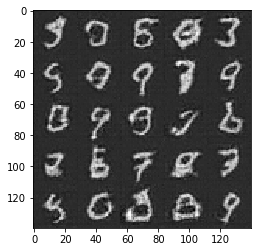

Epoch 6/100... Discriminator Loss: 0.1632... Generator Loss: 2.7168
Epoch 6/100... Discriminator Loss: 0.2350... Generator Loss: 2.5357
Epoch 6/100... Discriminator Loss: 0.2075... Generator Loss: 2.2924
Epoch 6/100... Discriminator Loss: 0.2129... Generator Loss: 2.5135
Epoch 6/100... Discriminator Loss: 0.1984... Generator Loss: 2.7184
Epoch 6/100... Discriminator Loss: 0.3722... Generator Loss: 1.6324
Epoch 6/100... Discriminator Loss: 0.2366... Generator Loss: 2.7067
Epoch 6/100... Discriminator Loss: 0.3488... Generator Loss: 1.9457
Epoch 6/100... Discriminator Loss: 0.2001... Generator Loss: 2.9102
Epoch 6/100... Discriminator Loss: 0.2050... Generator Loss: 3.0039


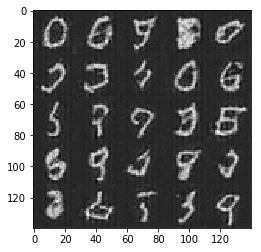

Epoch 6/100... Discriminator Loss: 0.1667... Generator Loss: 2.6802
Epoch 6/100... Discriminator Loss: 0.1831... Generator Loss: 2.6604
Epoch 6/100... Discriminator Loss: 0.2181... Generator Loss: 3.1180
Epoch 6/100... Discriminator Loss: 0.1961... Generator Loss: 2.8140
Epoch 6/100... Discriminator Loss: 0.1804... Generator Loss: 2.6223
Epoch 6/100... Discriminator Loss: 0.2727... Generator Loss: 1.8850
Epoch 6/100... Discriminator Loss: 0.2474... Generator Loss: 2.5137
Epoch 6/100... Discriminator Loss: 0.2816... Generator Loss: 2.2035
Epoch 6/100... Discriminator Loss: 0.2153... Generator Loss: 3.0584
Epoch 6/100... Discriminator Loss: 0.1605... Generator Loss: 2.6592


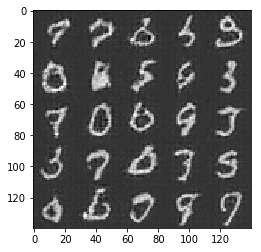

Epoch 7/100... Discriminator Loss: 0.1617... Generator Loss: 3.2623
Epoch 7/100... Discriminator Loss: 0.2670... Generator Loss: 1.8644
Epoch 7/100... Discriminator Loss: 8.7622... Generator Loss: 6.6144
Epoch 7/100... Discriminator Loss: 1.1444... Generator Loss: 4.2919
Epoch 7/100... Discriminator Loss: 0.3372... Generator Loss: 2.1315
Epoch 7/100... Discriminator Loss: 0.6157... Generator Loss: 1.0158
Epoch 7/100... Discriminator Loss: 0.3383... Generator Loss: 2.2474
Epoch 7/100... Discriminator Loss: 0.4541... Generator Loss: 1.3110
Epoch 7/100... Discriminator Loss: 0.3175... Generator Loss: 2.3019
Epoch 7/100... Discriminator Loss: 0.3880... Generator Loss: 2.1173


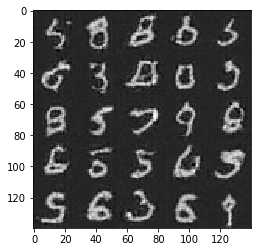

Epoch 7/100... Discriminator Loss: 0.2425... Generator Loss: 2.0964
Epoch 7/100... Discriminator Loss: 0.2617... Generator Loss: 2.0124
Epoch 7/100... Discriminator Loss: 0.4273... Generator Loss: 1.4926
Epoch 7/100... Discriminator Loss: 0.2224... Generator Loss: 2.3441
Epoch 7/100... Discriminator Loss: 0.2117... Generator Loss: 2.3228
Epoch 7/100... Discriminator Loss: 0.1218... Generator Loss: 3.0803
Epoch 7/100... Discriminator Loss: 0.1873... Generator Loss: 2.3281
Epoch 7/100... Discriminator Loss: 0.2666... Generator Loss: 2.1908
Epoch 7/100... Discriminator Loss: 0.2808... Generator Loss: 3.4575
Epoch 7/100... Discriminator Loss: 0.2546... Generator Loss: 2.6250


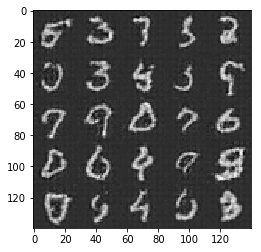

Epoch 7/100... Discriminator Loss: 0.2105... Generator Loss: 2.3823
Epoch 7/100... Discriminator Loss: 0.4963... Generator Loss: 2.2082
Epoch 7/100... Discriminator Loss: 0.2357... Generator Loss: 2.2956
Epoch 7/100... Discriminator Loss: 0.3605... Generator Loss: 2.2219
Epoch 7/100... Discriminator Loss: 0.2387... Generator Loss: 2.3581
Epoch 7/100... Discriminator Loss: 0.2238... Generator Loss: 2.3349
Epoch 7/100... Discriminator Loss: 0.3108... Generator Loss: 2.0743
Epoch 7/100... Discriminator Loss: 0.1749... Generator Loss: 2.8779
Epoch 7/100... Discriminator Loss: 0.1943... Generator Loss: 2.3517
Epoch 7/100... Discriminator Loss: 0.1621... Generator Loss: 2.7942


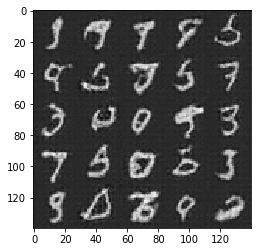

Epoch 7/100... Discriminator Loss: 0.1990... Generator Loss: 2.9330
Epoch 7/100... Discriminator Loss: 0.2789... Generator Loss: 3.1048
Epoch 7/100... Discriminator Loss: 0.2199... Generator Loss: 2.4733
Epoch 7/100... Discriminator Loss: 0.2069... Generator Loss: 2.6345
Epoch 7/100... Discriminator Loss: 0.2894... Generator Loss: 1.8625
Epoch 7/100... Discriminator Loss: 0.1538... Generator Loss: 3.2032
Epoch 7/100... Discriminator Loss: 0.1477... Generator Loss: 2.8592
Epoch 7/100... Discriminator Loss: 0.1918... Generator Loss: 2.3033
Epoch 7/100... Discriminator Loss: 0.2283... Generator Loss: 2.0469
Epoch 7/100... Discriminator Loss: 0.1878... Generator Loss: 2.9279


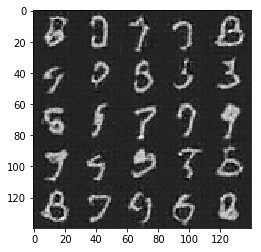

Epoch 7/100... Discriminator Loss: 0.1766... Generator Loss: 2.5347
Epoch 7/100... Discriminator Loss: 0.1586... Generator Loss: 2.6786
Epoch 7/100... Discriminator Loss: 0.1842... Generator Loss: 3.6384
Epoch 7/100... Discriminator Loss: 0.1638... Generator Loss: 2.9552
Epoch 7/100... Discriminator Loss: 0.3306... Generator Loss: 1.8799
Epoch 7/100... Discriminator Loss: 0.2549... Generator Loss: 2.3813
Epoch 7/100... Discriminator Loss: 0.2573... Generator Loss: 1.9753
Epoch 8/100... Discriminator Loss: 0.3453... Generator Loss: 1.6602
Epoch 8/100... Discriminator Loss: 0.1648... Generator Loss: 2.7938
Epoch 8/100... Discriminator Loss: 0.1474... Generator Loss: 2.8053


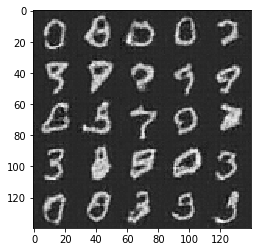

Epoch 8/100... Discriminator Loss: 0.2474... Generator Loss: 4.1989
Epoch 8/100... Discriminator Loss: 0.2197... Generator Loss: 2.4711
Epoch 8/100... Discriminator Loss: 0.1827... Generator Loss: 2.5743
Epoch 8/100... Discriminator Loss: 0.1510... Generator Loss: 2.9308
Epoch 8/100... Discriminator Loss: 0.2300... Generator Loss: 2.3103
Epoch 8/100... Discriminator Loss: 0.1845... Generator Loss: 3.1949
Epoch 8/100... Discriminator Loss: 0.9219... Generator Loss: 0.6891
Epoch 8/100... Discriminator Loss: 1.8068... Generator Loss: 0.3404
Epoch 8/100... Discriminator Loss: 0.5273... Generator Loss: 2.8258
Epoch 8/100... Discriminator Loss: 0.5106... Generator Loss: 2.3053


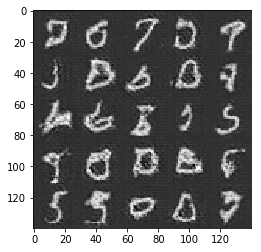

Epoch 8/100... Discriminator Loss: 0.3837... Generator Loss: 1.6628
Epoch 8/100... Discriminator Loss: 0.3936... Generator Loss: 2.0082
Epoch 8/100... Discriminator Loss: 0.3246... Generator Loss: 1.8577
Epoch 8/100... Discriminator Loss: 0.2636... Generator Loss: 2.8608
Epoch 8/100... Discriminator Loss: 0.4730... Generator Loss: 1.3126
Epoch 8/100... Discriminator Loss: 0.2152... Generator Loss: 2.4918
Epoch 8/100... Discriminator Loss: 0.2921... Generator Loss: 2.1675
Epoch 8/100... Discriminator Loss: 0.2101... Generator Loss: 2.2971
Epoch 8/100... Discriminator Loss: 0.4366... Generator Loss: 1.3719
Epoch 8/100... Discriminator Loss: 0.2340... Generator Loss: 2.2781


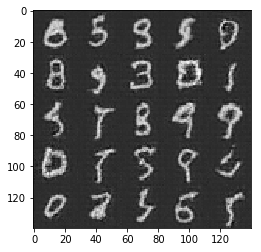

Epoch 8/100... Discriminator Loss: 0.2328... Generator Loss: 2.2268
Epoch 8/100... Discriminator Loss: 0.1782... Generator Loss: 2.7904
Epoch 8/100... Discriminator Loss: 0.3385... Generator Loss: 3.5203
Epoch 8/100... Discriminator Loss: 0.2008... Generator Loss: 2.3365
Epoch 8/100... Discriminator Loss: 0.1784... Generator Loss: 2.3624
Epoch 8/100... Discriminator Loss: 0.1704... Generator Loss: 2.7889
Epoch 8/100... Discriminator Loss: 0.2078... Generator Loss: 2.6110
Epoch 8/100... Discriminator Loss: 0.2105... Generator Loss: 2.3377
Epoch 8/100... Discriminator Loss: 0.1633... Generator Loss: 3.0189
Epoch 8/100... Discriminator Loss: 0.1747... Generator Loss: 3.1504


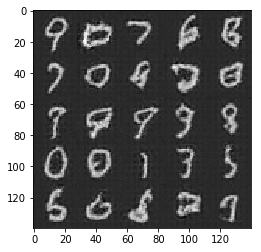

Epoch 8/100... Discriminator Loss: 0.1929... Generator Loss: 2.3210
Epoch 8/100... Discriminator Loss: 0.1664... Generator Loss: 2.8652
Epoch 8/100... Discriminator Loss: 0.3441... Generator Loss: 3.7858
Epoch 8/100... Discriminator Loss: 0.4854... Generator Loss: 1.9232
Epoch 8/100... Discriminator Loss: 0.3778... Generator Loss: 1.9303
Epoch 8/100... Discriminator Loss: 0.3960... Generator Loss: 1.7438
Epoch 8/100... Discriminator Loss: 0.3704... Generator Loss: 1.9220
Epoch 8/100... Discriminator Loss: 0.3074... Generator Loss: 2.4684
Epoch 8/100... Discriminator Loss: 0.3560... Generator Loss: 1.8976
Epoch 8/100... Discriminator Loss: 0.2630... Generator Loss: 2.2821


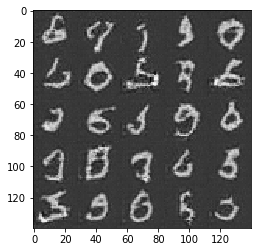

Epoch 8/100... Discriminator Loss: 0.2762... Generator Loss: 2.6790
Epoch 8/100... Discriminator Loss: 0.2529... Generator Loss: 2.2968
Epoch 8/100... Discriminator Loss: 0.3429... Generator Loss: 1.7953
Epoch 8/100... Discriminator Loss: 0.2687... Generator Loss: 2.6326
Epoch 9/100... Discriminator Loss: 0.3451... Generator Loss: 1.7165
Epoch 9/100... Discriminator Loss: 0.3587... Generator Loss: 3.4476
Epoch 9/100... Discriminator Loss: 0.2872... Generator Loss: 2.1209
Epoch 9/100... Discriminator Loss: 0.1931... Generator Loss: 2.6582
Epoch 9/100... Discriminator Loss: 0.1772... Generator Loss: 2.7913
Epoch 9/100... Discriminator Loss: 0.2748... Generator Loss: 1.9669


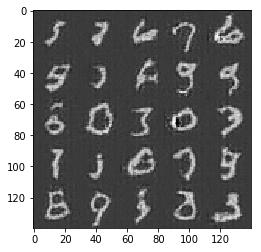

Epoch 9/100... Discriminator Loss: 0.3670... Generator Loss: 1.5564
Epoch 9/100... Discriminator Loss: 0.3049... Generator Loss: 1.8568
Epoch 9/100... Discriminator Loss: 0.2134... Generator Loss: 2.3043
Epoch 9/100... Discriminator Loss: 0.2571... Generator Loss: 2.3415
Epoch 9/100... Discriminator Loss: 0.1090... Generator Loss: 3.1545
Epoch 9/100... Discriminator Loss: 0.2326... Generator Loss: 2.1490
Epoch 9/100... Discriminator Loss: 0.1883... Generator Loss: 2.5266
Epoch 9/100... Discriminator Loss: 0.2031... Generator Loss: 2.2691
Epoch 9/100... Discriminator Loss: 0.9459... Generator Loss: 0.7395
Epoch 9/100... Discriminator Loss: 0.2508... Generator Loss: 2.1955


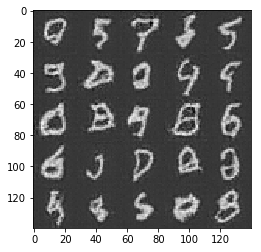

Epoch 9/100... Discriminator Loss: 0.7883... Generator Loss: 0.8686
Epoch 9/100... Discriminator Loss: 0.1942... Generator Loss: 2.9293
Epoch 9/100... Discriminator Loss: 0.1809... Generator Loss: 2.5174
Epoch 9/100... Discriminator Loss: 0.2587... Generator Loss: 2.2158
Epoch 9/100... Discriminator Loss: 0.1523... Generator Loss: 2.8124
Epoch 9/100... Discriminator Loss: 0.3731... Generator Loss: 1.5967
Epoch 9/100... Discriminator Loss: 0.1649... Generator Loss: 2.7727
Epoch 9/100... Discriminator Loss: 0.0979... Generator Loss: 3.6397
Epoch 9/100... Discriminator Loss: 0.3130... Generator Loss: 1.8437
Epoch 9/100... Discriminator Loss: 0.2648... Generator Loss: 2.0733


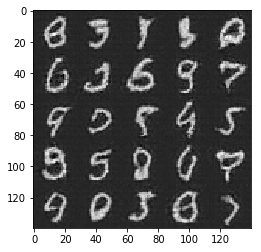

Epoch 9/100... Discriminator Loss: 1.4446... Generator Loss: 1.8948
Epoch 9/100... Discriminator Loss: 0.4759... Generator Loss: 2.6888
Epoch 9/100... Discriminator Loss: 0.4585... Generator Loss: 1.4986
Epoch 9/100... Discriminator Loss: 0.3162... Generator Loss: 2.0929
Epoch 9/100... Discriminator Loss: 0.2075... Generator Loss: 2.6027
Epoch 9/100... Discriminator Loss: 0.3151... Generator Loss: 1.8699
Epoch 9/100... Discriminator Loss: 0.3292... Generator Loss: 1.8382
Epoch 9/100... Discriminator Loss: 0.3177... Generator Loss: 2.1955
Epoch 9/100... Discriminator Loss: 0.2614... Generator Loss: 2.6163
Epoch 9/100... Discriminator Loss: 0.2815... Generator Loss: 2.8419


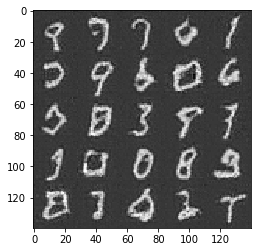

Epoch 9/100... Discriminator Loss: 0.2640... Generator Loss: 2.3220
Epoch 9/100... Discriminator Loss: 0.2660... Generator Loss: 2.1961
Epoch 9/100... Discriminator Loss: 0.3181... Generator Loss: 2.1244
Epoch 9/100... Discriminator Loss: 0.2694... Generator Loss: 2.5845
Epoch 9/100... Discriminator Loss: 0.1699... Generator Loss: 2.6614
Epoch 9/100... Discriminator Loss: 0.2094... Generator Loss: 2.5714
Epoch 9/100... Discriminator Loss: 0.2884... Generator Loss: 1.7952
Epoch 9/100... Discriminator Loss: 0.1946... Generator Loss: 2.8717
Epoch 9/100... Discriminator Loss: 0.3490... Generator Loss: 1.8656
Epoch 9/100... Discriminator Loss: 0.2652... Generator Loss: 2.0193


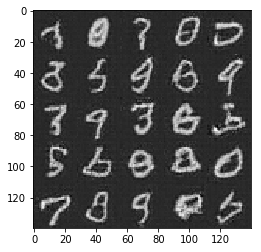

Epoch 9/100... Discriminator Loss: 0.1952... Generator Loss: 2.4139
Epoch 10/100... Discriminator Loss: 0.1989... Generator Loss: 2.9530
Epoch 10/100... Discriminator Loss: 0.2198... Generator Loss: 2.5440
Epoch 10/100... Discriminator Loss: 0.3464... Generator Loss: 1.7558
Epoch 10/100... Discriminator Loss: 0.2034... Generator Loss: 2.9416
Epoch 10/100... Discriminator Loss: 0.1577... Generator Loss: 2.9936
Epoch 10/100... Discriminator Loss: 0.1868... Generator Loss: 2.7297
Epoch 10/100... Discriminator Loss: 0.2080... Generator Loss: 3.7024
Epoch 10/100... Discriminator Loss: 0.0928... Generator Loss: 3.5133
Epoch 10/100... Discriminator Loss: 0.1396... Generator Loss: 2.9967


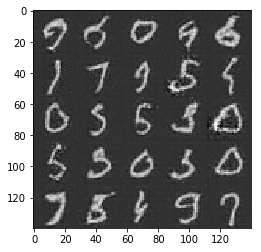

Epoch 10/100... Discriminator Loss: 0.1137... Generator Loss: 3.1958
Epoch 10/100... Discriminator Loss: 0.2955... Generator Loss: 4.1285
Epoch 10/100... Discriminator Loss: 0.2021... Generator Loss: 2.6065
Epoch 10/100... Discriminator Loss: 0.2932... Generator Loss: 2.0180
Epoch 10/100... Discriminator Loss: 0.3726... Generator Loss: 1.6989
Epoch 10/100... Discriminator Loss: 0.1944... Generator Loss: 3.3540
Epoch 10/100... Discriminator Loss: 0.3871... Generator Loss: 1.6147
Epoch 10/100... Discriminator Loss: 2.2727... Generator Loss: 0.2382
Epoch 10/100... Discriminator Loss: 0.7736... Generator Loss: 2.7204
Epoch 10/100... Discriminator Loss: 0.4355... Generator Loss: 1.8191


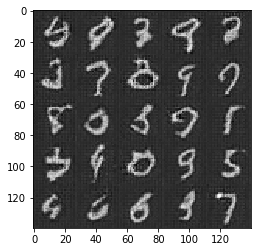

Epoch 10/100... Discriminator Loss: 0.5102... Generator Loss: 1.3643
Epoch 10/100... Discriminator Loss: 0.3766... Generator Loss: 1.8629
Epoch 10/100... Discriminator Loss: 0.3582... Generator Loss: 1.9811
Epoch 10/100... Discriminator Loss: 0.4717... Generator Loss: 1.3619
Epoch 10/100... Discriminator Loss: 0.2992... Generator Loss: 2.0857
Epoch 10/100... Discriminator Loss: 0.2939... Generator Loss: 2.2124
Epoch 10/100... Discriminator Loss: 0.1971... Generator Loss: 2.2692
Epoch 10/100... Discriminator Loss: 0.2188... Generator Loss: 2.2479
Epoch 10/100... Discriminator Loss: 0.3352... Generator Loss: 1.8217
Epoch 10/100... Discriminator Loss: 0.3145... Generator Loss: 1.8698


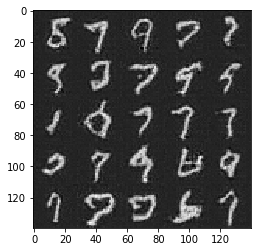

Epoch 10/100... Discriminator Loss: 0.2375... Generator Loss: 2.3584
Epoch 10/100... Discriminator Loss: 0.2410... Generator Loss: 2.1592
Epoch 10/100... Discriminator Loss: 0.3510... Generator Loss: 1.7299
Epoch 10/100... Discriminator Loss: 0.1546... Generator Loss: 2.8321
Epoch 10/100... Discriminator Loss: 0.2207... Generator Loss: 2.8913
Epoch 10/100... Discriminator Loss: 0.2072... Generator Loss: 2.3719
Epoch 10/100... Discriminator Loss: 0.2501... Generator Loss: 2.3803
Epoch 10/100... Discriminator Loss: 0.2138... Generator Loss: 2.3307
Epoch 10/100... Discriminator Loss: 0.2365... Generator Loss: 2.1604
Epoch 10/100... Discriminator Loss: 0.2154... Generator Loss: 2.2096


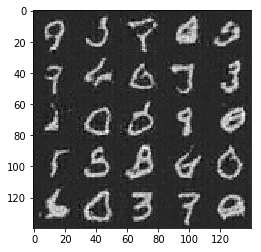

Epoch 10/100... Discriminator Loss: 0.1655... Generator Loss: 3.1811
Epoch 10/100... Discriminator Loss: 0.1857... Generator Loss: 2.5250
Epoch 10/100... Discriminator Loss: 0.1849... Generator Loss: 2.4880
Epoch 10/100... Discriminator Loss: 0.2715... Generator Loss: 1.9404
Epoch 10/100... Discriminator Loss: 0.1991... Generator Loss: 2.6683
Epoch 10/100... Discriminator Loss: 0.3011... Generator Loss: 1.9647
Epoch 10/100... Discriminator Loss: 0.1365... Generator Loss: 3.0418
Epoch 10/100... Discriminator Loss: 0.1786... Generator Loss: 2.3875
Epoch 11/100... Discriminator Loss: 0.2369... Generator Loss: 2.2261
Epoch 11/100... Discriminator Loss: 0.2711... Generator Loss: 1.9764


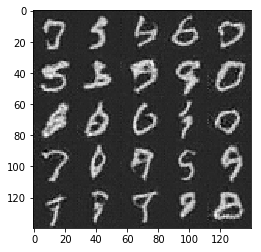

Epoch 11/100... Discriminator Loss: 0.1478... Generator Loss: 2.7266
Epoch 11/100... Discriminator Loss: 1.1017... Generator Loss: 5.9709
Epoch 11/100... Discriminator Loss: 0.3396... Generator Loss: 1.7230
Epoch 11/100... Discriminator Loss: 0.1776... Generator Loss: 2.4636
Epoch 11/100... Discriminator Loss: 0.2371... Generator Loss: 2.1819
Epoch 11/100... Discriminator Loss: 0.1839... Generator Loss: 2.4119
Epoch 11/100... Discriminator Loss: 0.2844... Generator Loss: 3.7933
Epoch 11/100... Discriminator Loss: 0.1160... Generator Loss: 2.9767
Epoch 11/100... Discriminator Loss: 0.1584... Generator Loss: 2.5954
Epoch 11/100... Discriminator Loss: 0.1552... Generator Loss: 2.7925


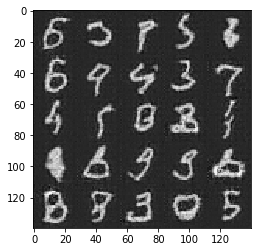

Epoch 11/100... Discriminator Loss: 0.1818... Generator Loss: 3.6644
Epoch 11/100... Discriminator Loss: 0.1482... Generator Loss: 2.9573
Epoch 11/100... Discriminator Loss: 0.1051... Generator Loss: 4.0623


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 100

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### Download CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

In [ ]:
helper.download_extract('celeba', data_dir)
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.